# Geospatial Matching Optimization

This project is designed to showcase how to improve the speed of a polygon matching procedure. There are two main areas that could benefit from taking a "geospatial-native" approach:

1. Data encoding, fetching, and storage
2. Searching for Overlaps

We will generate synthetic polygon data and use both a non-geospatial-native and geospatial-native approach, comparing execution time for both to see how they differ.

## Imports

In [683]:
import geopandas as gpd
import pandas as pd
import shapely
import h3
import time
import helpers as h
import parallel_processing as p
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from shapely.wkt import dumps, loads
from pathlib import Path
import multiprocessing as mp
import datetime
import psycopg2
from psycopg2 import sql, extras
import random

# ensure helpers is loaded correctly
import importlib
importlib.reload(h)
importlib.reload(p)

<module 'parallel_processing' from '/Users/sra/files/projects/matching_optimization/parallel_processing.py'>

## Retrieve Generated Test Data

In [684]:
# prev_month_blobs = gpd.read_parquet('data/prev_month_blobs_5k.parquet')
# curr_month_blobs = gpd.read_parquet('data/curr_month_blobs_5k.parquet')
prev_month_blobs = gpd.read_parquet('data/prev_month_blobs_10k.parquet')
curr_month_blobs = gpd.read_parquet('data/curr_month_blobs_10k.parquet')

In [685]:
# save to geojson to confirm in QGIS
blobs_geojson = Path('data/prev_month_blobs.geojson')
if not blobs_geojson.is_file():
    prev_month_blobs.to_file('data/prev_month_blobs.geojson')
    curr_month_blobs.to_file('data/curr_month_blobs.geojson')

In [686]:
prev_month_blobs.head()

,id,geohash,geometry
0,e22ae998-6873-4924-93fb-d2618235dda8,dhy33u,"POLYGON ((-81.17040 26.94651, -81.08065 26.946..."
1,dac8e2f3-e09b-49a0-b8e4-d7a65eb02d3c,dhy4tz,"POLYGON ((-81.31626 27.17619, -81.30139 27.176..."
2,609e736e-86f3-4cf6-8431-f6c4e758e34c,dhy55j,"POLYGON ((-81.45706 27.23212, -81.38565 27.232..."
3,060438ef-f5c2-4379-859d-9a2ee8086893,dhye8f,"POLYGON ((-80.86148 27.33751, -80.77728 27.337..."
4,893f78cc-d272-4042-b7cd-f61afee7968a,dhy79e,"POLYGON ((-81.18868 27.33882, -81.08989 27.338..."


In [687]:
curr_month_blobs.head()

,id,geohash,geometry
0,46f93aaa-7cb6-475b-8eb5-72bf5882950f,dhvf23,"POLYGON ((-81.92436 27.07050, -81.87900 27.070..."
1,2bb00d73-c2b9-43a2-9e3b-2dd38c6493fb,dhvtv8,"POLYGON ((-82.06132 27.71268, -81.98629 27.712..."
2,6515ab07-9d0e-408f-a5c9-8ffc339a4915,dhvtfq,"POLYGON ((-82.20622 27.75900, -82.11353 27.759..."
3,f3f03f5a-9155-401b-836f-fecfc8aa4ecb,dhvwhn,"POLYGON ((-82.11181 27.80411, -82.04807 27.804..."
4,fb52db32-f936-40cc-b78b-cb7aa20f2a51,dhvrp1,"POLYGON ((-82.31873 27.93551, -82.28148 27.935..."


We have to redefine the order of the columns:

In [688]:
prev_month_blobs = prev_month_blobs[['geometry', 'id', 'geohash']]
prev_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.17040 26.94651, -81.08065 26.946...",e22ae998-6873-4924-93fb-d2618235dda8,dhy33u
1,"POLYGON ((-81.31626 27.17619, -81.30139 27.176...",dac8e2f3-e09b-49a0-b8e4-d7a65eb02d3c,dhy4tz
2,"POLYGON ((-81.45706 27.23212, -81.38565 27.232...",609e736e-86f3-4cf6-8431-f6c4e758e34c,dhy55j
3,"POLYGON ((-80.86148 27.33751, -80.77728 27.337...",060438ef-f5c2-4379-859d-9a2ee8086893,dhye8f
4,"POLYGON ((-81.18868 27.33882, -81.08989 27.338...",893f78cc-d272-4042-b7cd-f61afee7968a,dhy79e


In [689]:
curr_month_blobs = curr_month_blobs[['geometry', 'id', 'geohash']]
curr_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.92436 27.07050, -81.87900 27.070...",46f93aaa-7cb6-475b-8eb5-72bf5882950f,dhvf23
1,"POLYGON ((-82.06132 27.71268, -81.98629 27.712...",2bb00d73-c2b9-43a2-9e3b-2dd38c6493fb,dhvtv8
2,"POLYGON ((-82.20622 27.75900, -82.11353 27.759...",6515ab07-9d0e-408f-a5c9-8ffc339a4915,dhvtfq
3,"POLYGON ((-82.11181 27.80411, -82.04807 27.804...",f3f03f5a-9155-401b-836f-fecfc8aa4ecb,dhvwhn
4,"POLYGON ((-82.31873 27.93551, -82.28148 27.935...",fb52db32-f936-40cc-b78b-cb7aa20f2a51,dhvrp1


In [690]:
# overwrite them with correct column order
# make data folder
Path('data/').mkdir(exist_ok=True)

# save as geoparquet
prev_month_blobs.to_parquet('data/prev_month_blobs.parquet')
curr_month_blobs.to_parquet('data/curr_month_blobs.parquet')

In [691]:
# range_ = 10000

# fig, ax = plt.subplots(figsize=(5, 5))
# prev_month_blobs.iloc[0:range_].plot(ax=ax)
# ax.set_title(f'Viewing the first {range_} blobs')
# plt.tight_layout()

# plt.show()

## 1. Non-optimized process

### 1.1. Data encoding, storage, and fetching

We will use PostgreSQL and string storage for geographic information.

#### Make copy of polygon layer and convert to non-geospatial-native string (WKT) datatype

In [692]:
# copy the gdfs
prev_month_blobs_wkt = prev_month_blobs.copy()
curr_month_blobs_wkt = curr_month_blobs.copy()

In [693]:
# Convert WKT versions to strings
dfs_to_convert = [prev_month_blobs_wkt, curr_month_blobs_wkt]
prev_month_blobs_wkt, curr_month_blobs_wkt = [h.convert_col_to_string(df) for df in dfs_to_convert]

# Check result
print(prev_month_blobs_wkt.head())

Function `convert_col_to_string` executed in 0.0485 sec, CPU: 14.90%, Memory: 19.77MB
Function `convert_col_to_string` executed in 0.0451 sec, CPU: 0.00%, Memory: 0.00MB
                                            geometry  \
0  POLYGON ((-81.170395 26.946513, -81.080646 26....   
1  POLYGON ((-81.31626 27.176188, -81.30139 27.17...   
2  POLYGON ((-81.45706 27.23212, -81.385653 27.23...   
3  POLYGON ((-80.861484 27.337506, -80.777282 27....   
4  POLYGON ((-81.188677 27.33882, -81.089889 27.3...   

                                     id geohash  
0  e22ae998-6873-4924-93fb-d2618235dda8  dhy33u  
1  dac8e2f3-e09b-49a0-b8e4-d7a65eb02d3c  dhy4tz  
2  609e736e-86f3-4cf6-8431-f6c4e758e34c  dhy55j  
3  060438ef-f5c2-4379-859d-9a2ee8086893  dhye8f  
4  893f78cc-d272-4042-b7cd-f61afee7968a  dhy79e  


/Users/sra/files/projects/matching_optimization/helpers.py:214: UserWarning: Geometry column does not contain geometry.
  df[col] = df[col].apply(lambda geom: to_wkt(geom) if isinstance(geom, BaseGeometry) else str(geom))
/Users/sra/files/projects/matching_optimization/helpers.py:214: UserWarning: Geometry column does not contain geometry.
  df[col] = df[col].apply(lambda geom: to_wkt(geom) if isinstance(geom, BaseGeometry) else str(geom))


#### Save in PostgreSQL database

This is a simple version of what a "non-geospatial-native" data ingestion pipeline may look like, with the primary example being that the polygons are stored as strings, not in a spatial-friendly datatype.

In [694]:
# Convert to tuples
prev_month_blobs_wkt = h.df_itertuple(prev_month_blobs_wkt)
curr_month_blobs_wkt = h.df_itertuple(curr_month_blobs_wkt)

Function `df_itertuple` executed in 0.0030 sec, CPU: 0.00%, Memory: 0.00MB
Function `df_itertuple` executed in 0.0024 sec, CPU: 0.00%, Memory: 0.00MB


Create PostgreSQL database if it doesn't exist already. We will be using the default settings. If they need to be adjusted, refer to [`helpers.py`](helpers.py).

In [695]:
h.create_pg_db()

Database blob_matching already exists.
Function `create_pg_db` executed in 0.0396 sec, CPU: 0.00%, Memory: 0.00MB


Create and insert into tables:

In [696]:
prev_month_blobs.head(1)

,geometry,id,geohash
0,"POLYGON ((-81.17040 26.94651, -81.08065 26.946...",e22ae998-6873-4924-93fb-d2618235dda8,dhy33u


In [697]:
prev_month_blobs_wkt[0]

('POLYGON ((-81.170395 26.946513, -81.080646 26.946513, -81.080646 26.975474, -81.170395 26.975474, -81.170395 26.946513))',
 'e22ae998-6873-4924-93fb-d2618235dda8',
 'dhy33u')

In [698]:
h.create_pg_table(table_name='prev_blobs_wkt', data=prev_month_blobs_wkt, truncate=True)
h.create_pg_table(table_name='curr_blobs_wkt', data=curr_month_blobs_wkt, truncate=True)

Table prev_blobs_wkt truncated.
Inserted 10000 records into prev_blobs_wkt.
Function `create_pg_table` executed in 0.4560 sec, CPU: 0.00%, Memory: 0.00MB
Table curr_blobs_wkt truncated.
Inserted 10000 records into curr_blobs_wkt.
Function `create_pg_table` executed in 0.3642 sec, CPU: 32.80%, Memory: 62.02MB


Retrieve data as GeoDataFrames to confirm that it worked:

In [699]:
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

Retrieved 10000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0443 sec, CPU: 10.60%, Memory: 1.69MB
Retrieved 10000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0450 sec, CPU: 22.90%, Memory: 8.28MB


Compare the tables before and after for a sanity check:

In [700]:
df_prev.head()

,geometry,id,geohash
0,"POLYGON ((-81.170395 26.946513, -81.080646 26....",e22ae998-6873-4924-93fb-d2618235dda8,dhy33u
1,"POLYGON ((-81.31626 27.176188, -81.30139 27.17...",dac8e2f3-e09b-49a0-b8e4-d7a65eb02d3c,dhy4tz
2,"POLYGON ((-81.45706 27.23212, -81.385653 27.23...",609e736e-86f3-4cf6-8431-f6c4e758e34c,dhy55j
3,"POLYGON ((-80.861484 27.337506, -80.777282 27....",060438ef-f5c2-4379-859d-9a2ee8086893,dhye8f
4,"POLYGON ((-81.188677 27.33882, -81.089889 27.3...",893f78cc-d272-4042-b7cd-f61afee7968a,dhy79e


In [701]:
prev_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.17040 26.94651, -81.08065 26.946...",e22ae998-6873-4924-93fb-d2618235dda8,dhy33u
1,"POLYGON ((-81.31626 27.17619, -81.30139 27.176...",dac8e2f3-e09b-49a0-b8e4-d7a65eb02d3c,dhy4tz
2,"POLYGON ((-81.45706 27.23212, -81.38565 27.232...",609e736e-86f3-4cf6-8431-f6c4e758e34c,dhy55j
3,"POLYGON ((-80.86148 27.33751, -80.77728 27.337...",060438ef-f5c2-4379-859d-9a2ee8086893,dhye8f
4,"POLYGON ((-81.18868 27.33882, -81.08989 27.338...",893f78cc-d272-4042-b7cd-f61afee7968a,dhy79e


Confirm that the original blob dfs and the retrieved dfs are the same length:

In [702]:
def round_geometry(geom, precision=6):
    """Round all coordinates of a geometry to a given precision."""
    return shapely.wkt.loads(shapely.wkt.dumps(geom, rounding_precision=precision))

# Convert both to sets of rounded WKT strings
set_prev_month_blobs = set(prev_month_blobs['geometry'].apply(lambda g: round_geometry(g, precision=6).wkt))
set_df_prev = set(df_prev['geometry'].apply(lambda g: round_geometry(g, precision=6).wkt))

# Find common, missing, and extra geometries
common_geometries = set_prev_month_blobs & set_df_prev
missing_from_retrieved = set_prev_month_blobs - set_df_prev
extra_in_retrieved = set_df_prev - set_prev_month_blobs

# Print summary
print(f"Number of matching geometries: {len(common_geometries)}")
print(f"Missing geometries in retrieved table: {len(missing_from_retrieved)}")
print(f"Extra geometries in retrieved table: {len(extra_in_retrieved)}")

# Show an example missing/extra geometry for debugging
if missing_from_retrieved:
    print("Example missing record:", next(iter(missing_from_retrieved)))

if extra_in_retrieved:
    print("Example extra record:", next(iter(extra_in_retrieved)))

Number of matching geometries: 10000
Missing geometries in retrieved table: 0
Extra geometries in retrieved table: 0


It worked! Now we can proceed to "matching" any "previous" polygons that overlap with the "current" polygons.

### 1.2. Searching for Overlaps

We will search for overlapping polygons using GeoPandas.

In [703]:
start = datetime.datetime.now()
print('Start time:', start)
postgresql_details = h.pg_details()
p.run_parallel_matching_with_grid(
    table_prev='prev_blobs_wkt', 
    table_curr='curr_blobs_wkt', 
    output_table='matched_results', 
    postgresql_details=postgresql_details, 
    db_name='blob_matching', 
    num_workers=4,
    verbose=2
    )
end = datetime.datetime.now()
print('End time:', end)
print('Total time:', end - start)

Start time: 2025-03-04 01:10:37.663070
Table matched_results created successfully.
Total partitions to process: 4
Total matches found: 1559
Logging listener has shut down.
Function `run_parallel_matching_with_grid` executed in 2.2183 sec, CPU: 43.70%, Memory: 176.56MB
End time: 2025-03-04 01:10:39.882051
Total time: 0:00:02.218981


Confirm that the postgres matching table has the same number of matches:

In [704]:
count = h.retrieve_pg_table(table_name='matched_results', count=True)

Total matches in matched_results: 1559
Function `retrieve_pg_table` executed in 0.0055 sec, CPU: 33.30%, Memory: 0.00MB


In [705]:
# save log files as .parquet
h.convert_logs_to_parquet(csv_path=Path('logs/timing_results.csv'),
                          log_path=Path('logs/timing.log'))

Converted logs/timing_results.csv to logs/timing_results.parquet
Converted logs/timing.log to logs/timing_log.parquet


View the overall polygon layers and then some subplots with locations of the matched polygons:

Retrieved 10000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0464 sec, CPU: 13.10%, Memory: 6.06MB
Retrieved 10000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0495 sec, CPU: 26.80%, Memory: 3.19MB
Retrieved 1559 records from matched_results.


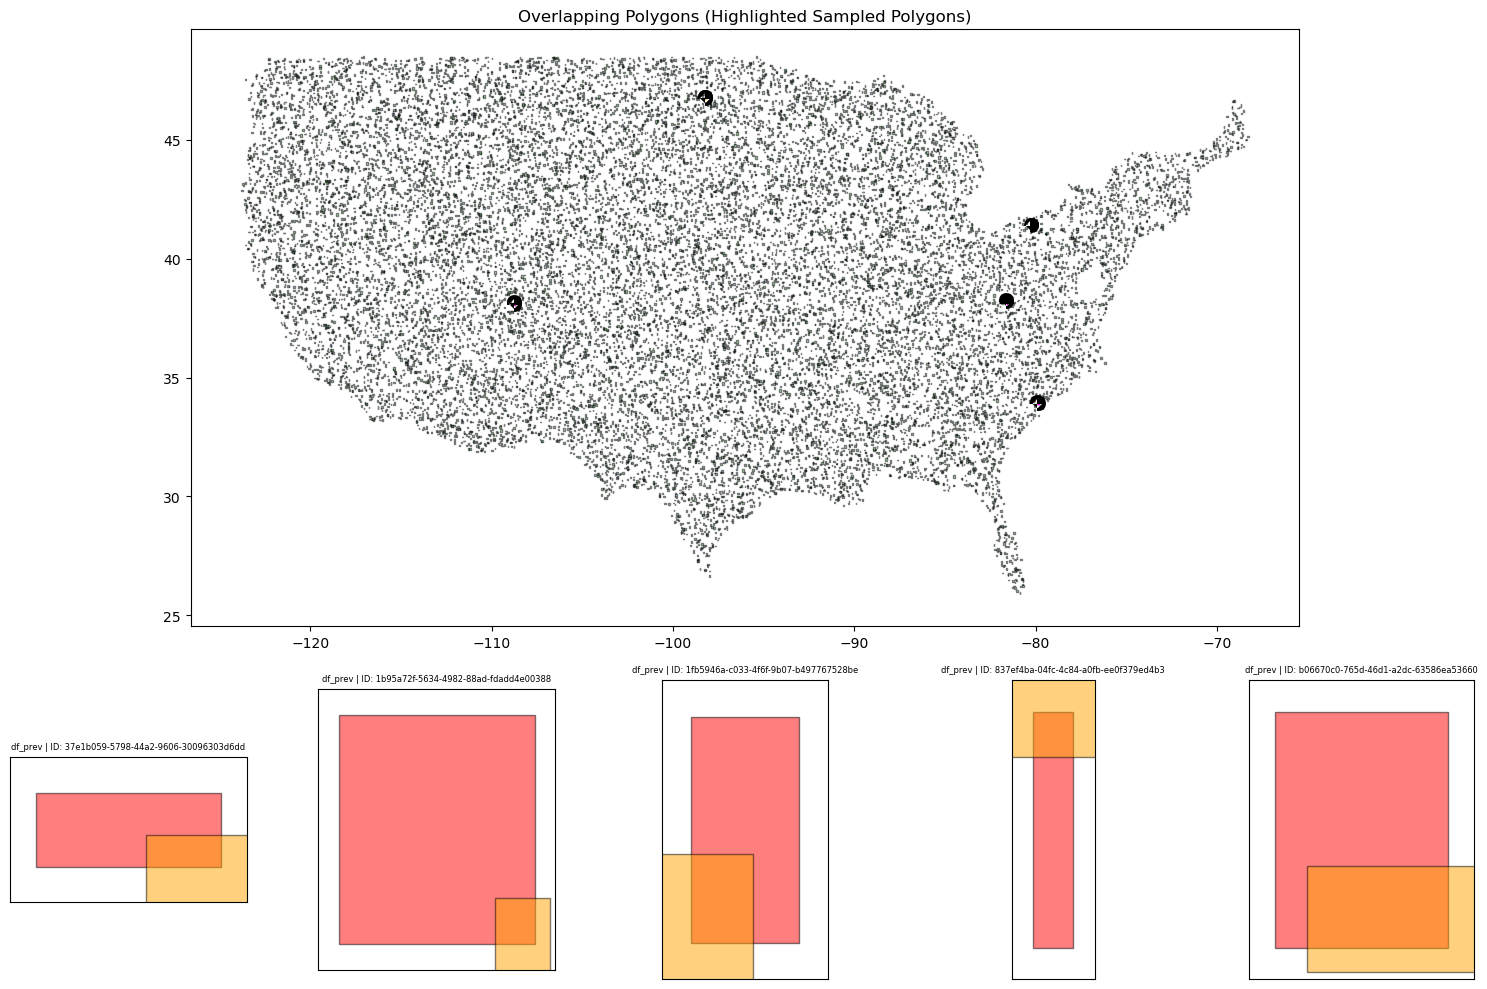

In [706]:
# --- Retrieve Data from PostgreSQL ---
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

# Ensure they are GeoDataFrames
df_prev = gpd.GeoDataFrame(df_prev, geometry='geometry', crs="EPSG:4326")
df_curr = gpd.GeoDataFrame(df_curr, geometry='geometry', crs="EPSG:4326")

# Retrieve matches table
table_name = 'matched_results'
postgresql_details['dbname'] = 'blob_matching'
conn = psycopg2.connect(**postgresql_details)
cur = conn.cursor()
cur.execute(f"SELECT prev_id, curr_id FROM {table_name};")
rows = cur.fetchall()
cur.close()
conn.close()

# Convert matches to DataFrame
matches = pd.DataFrame(rows, columns=["prev_id", "curr_id"])
print(f"Retrieved {len(matches)} records from {table_name}.")

# Find matching polygons
overlapping_a = df_prev[df_prev['id'].isin(matches['prev_id'])]
overlapping_b = df_curr[df_curr['id'].isin(matches['curr_id'])]

# --- Sample Overlapping Polygons ---
# Merge to ensure exact pairs before sampling
merged = matches.merge(overlapping_a, left_on="prev_id", right_on="id").merge(
    overlapping_b, left_on="curr_id", right_on="id", suffixes=("_prev", "_curr")
)

# Sample up to 5 matched pairs
sampled = merged.sample(n=min(5, len(merged)), random_state=42)

# debug
# print("Sampled columns:", sampled.columns)
# print("Overlapping_a columns:", overlapping_a.columns)
# print("Overlapping_b columns:", overlapping_b.columns)

# Extract individual DataFrames
sample_a = sampled[[col + "_prev" for col in overlapping_a.columns]]
sample_b = sampled[[col + "_curr" for col in overlapping_b.columns]]

# debug
# print("sample_a columns:", sample_a.columns)
# print("sample_b columns:", sample_b.columns)

# --- Define Figure Layout ---
fig = plt.figure(figsize=(15, 10))

# Main plot (2x height), subplots (1x height)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# --- Main Plot: Initial Polygons ---
ax_main = fig.add_subplot(gs[0])
df_prev.plot(ax=ax_main, color='lightblue', edgecolor='black', alpha=0.5, label="Previous", zorder=1)
df_curr.plot(ax=ax_main, color='lightgreen', edgecolor='black', alpha=0.5, label="Current", zorder=1)

# Highlight sampled polygons (plot the correct 'geometry' column directly)
sample_a.set_geometry('geometry_prev').plot(ax=ax_main, color='none', edgecolor='yellow', linewidth=1, linestyle='dashed', zorder=3)
sample_b.set_geometry('geometry_curr').plot(ax=ax_main, color='none', edgecolor='magenta', linewidth=1, linestyle='dashed', zorder=3)

# Emphasize selected polygons (plot the correct 'geometry' column directly)
sample_a.set_geometry('geometry_prev').plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)
sample_b.set_geometry('geometry_curr').plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)

ax_main.set_title("Overlapping Polygons (Highlighted Sampled Polygons)")

# --- Dynamic Subplots (Centered Below) ---
gs_subplots = gridspec.GridSpecFromSubplotSpec(1, sample_size, subplot_spec=gs[1], wspace=0.3)

for i, (idx, row) in enumerate(sample_a.iterrows()):
    ax = fig.add_subplot(gs_subplots[0, i])
    subset_a = sample_a.iloc[[i]]
    subset_b = sample_b.iloc[[i]]

    # Set geometry and plot explicitly by accessing the geometry
    subset_a = subset_a.set_geometry('geometry_prev')  # Ensure geometry is set
    subset_b = subset_b.set_geometry('geometry_curr')  # Ensure geometry is set

    # Plot the geometries explicitly
    subset_a.plot(ax=ax, color="red", edgecolor="black", alpha=0.5)
    subset_b.plot(ax=ax, color="orange", edgecolor="black", alpha=0.5)

    # Adjust zoom
    bounds = subset_a.geometry.bounds.values[0]  # Explicitly use .geometry for bounds
    buffer = 0.01
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

    # Titles & Aesthetics
    ax.set_title(f"df_prev | ID: {row['id_prev']}", fontsize=6)  # Use the appropriate ID column
    ax.set_xticks([])  
    ax.set_yticks([])

# Adjust layout and show
plt.tight_layout()

# plt.savefig('figs/overlapping_polygons_map_5k.pdf', bbox_inches='tight')
# plt.savefig('figs/overlapping_polygons_map_5k.png', bbox_inches='tight')

plt.savefig('figs/overlapping_polygons_map_10k.pdf', bbox_inches='tight')
plt.savefig('figs/overlapping_polygons_map_10k.png', bbox_inches='tight')

plt.show()

## 2. Optimized Approach

Having demonstrated a reasonable if not optimized way of matching polygons, we will now make use of geospatial-native tools to hopefully match polygons much more quickly.

My workflow centers around `DuckDB` and `H3` along with the `.parquet` format to efficiently store, retrieve, and process geospatial data. We will use `Apache Iceberg` as a layer over the parquet file as it allows for more robust table handling.

1. Prepare GeodataFrames with H3 Polyfill and parent hexagons at lower resolution.
   * Save as an Iceberg table.

2. Use DuckDB and the H3 extension to execute spatial SQL queries to find overlapping polygons with H3-based joins.

3. Save matching polygon IDs to a new Iceberg table.

4. Visualize the results.

### 2.1. Add H3 data to the blobs

H3 is a modern and efficient geospatial index paradigm that divides the world into nested hexagons.

In [681]:
prev_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.17040 26.94651, -81.08065 26.946...",e22ae998-6873-4924-93fb-d2618235dda8,dhy33u
1,"POLYGON ((-81.31626 27.17619, -81.30139 27.176...",dac8e2f3-e09b-49a0-b8e4-d7a65eb02d3c,dhy4tz
2,"POLYGON ((-81.45706 27.23212, -81.38565 27.232...",609e736e-86f3-4cf6-8431-f6c4e758e34c,dhy55j
3,"POLYGON ((-80.86148 27.33751, -80.77728 27.337...",060438ef-f5c2-4379-859d-9a2ee8086893,dhye8f
4,"POLYGON ((-81.18868 27.33882, -81.08989 27.338...",893f78cc-d272-4042-b7cd-f61afee7968a,dhy79e


In [903]:
def compute_h3_indices(geometry, centroid_res=6, polyfill_res=9):
    """
    Compute H3 indices for a polygon:
    - Single H3 index based on centroid
    - Full polygon coverage with H3 polyfill at high resolution
    """
    centroid = geometry.centroid
    h3_centroid = h3.geo_to_h3(centroid.y, centroid.x, centroid_res)

    # Full coverage using polyfill
    h3_polyfill = list(h3.polyfill(geometry.__geo_interface__, polyfill_res))

    return h3_centroid, h3_polyfill

In [ ]:
test_prev = prev_month_blobs.copy()
test_curr = curr_month_blobs.copy()

for gdf in [test_prev, test_curr]:
    gdf['h3_centroid'] = gdf['geometry'].apply(lambda geom: compute_h3_indices(geom, 6, 9))

In [899]:
print(type(prev_month_blobs))
prev_month_blobs.head(3)
# prev_month_blobs = gpd.read_parquet('data/prev_month_blobs.parquet')
# curr_month_blobs = gpd.read_parquet('data/curr_month_blobs.parquet')

<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry,id,geohash
0,"POLYGON ((-81.10504 26.01885, -81.04984 26.018...",6cc95c8a-cbaf-4993-a9ff-4e890c7e45f0,dhwk5h
1,"POLYGON ((-80.91675 26.04190, -80.86358 26.041...",a0fbead2-d8dc-4e05-b364-ab89d020fbfb,dhwkpq
2,"POLYGON ((-80.73525 26.20304, -80.71903 26.203...",b4c64915-35eb-4d74-a211-ce41ad8f21f8,dhwt55


# Notes on original process

geohash polygon into a larger region
match blobs using multiprocessing (mp.Process) and geopandas
find blobs from previous month that do not have a match

# 1 imports and setup

```python
import os, sys, traceback
import argparse
import cv2
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from skimage import io, color, measure
from tqdm import tqdm
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.validation import make_valid
import PIL
from PIL import Image, ImageDraw, ImageEnhance
import uuid
import multiprocessing as mp
from datetime import datetime
from sqlalchemy import or_
from sqlmodel import SQLModel, Session, create_engine, select
from pathlib import Path
```

## Key takeaways
- Uses Pandas and GeoPandas for data processing.
- Uses Shapely for geospatial geometry operations.
- Uses multiprocessing (mp) to parallelize the blob-matching process.
- Uses SQLAlchemy and SQLModel for database operations.

# 2 High-level script overview
The script is designed to match blobs (spatial objects) between two months and classify them into different business categories.

General Workflow
1. Fetch blobs from the previous and current months.
1. Convert the region of interest (state, city, county, or geohash) into a list of geohashes.
1. Parallelized Matching Process:
1. Process multiple geohashes at once using multiprocessing.
1. Find corresponding blobs from previous months for each geohash.
1. Classify blobs based on construction stage progression.
1. Identify blobs that are missing in the current month and "impute" them.
1. Save results into the database.

# 3 Blob classification logic

# 4 Blob matching

- Matches blobs between months using polygon intersections.
- Uses Shapely to validate geometries and check for overlaps.
- Returns matched blob IDs.

## Multiprocessing Optimization
The script parallelizes blob matching by:
- Uses multiprocessing (mp.Process) to divide the dataset into smaller batches.
- Each batch of blobs is processed in parallel.
- Reduces runtime compared to a single-threaded approach.

# 5 Handling unmatched blobs
- Finds blobs from the previous month that do not have a match in the current month.
- These blobs are "imputed", meaning they are carried over into the new month.

# 6 Main class to orchestrate process
- Loads previous and current month blobs.
- Converts input regions (state, city, county) into geohashes.

# Summary
- Parallel processing is used to match blobs.
- Blobs are classified based on construction stages.
- Unmatched blobs are imputed for continuity.
- The script writes results to a database.